In [18]:
import networkx as nx
import numpy as np
import json
import pylab
import pandas as pd
import math
from copy  import deepcopy as cp

In [ ]:
import stanza

In [2]:
from tqdm import tqdm

In [12]:
parser = stanza.Pipeline(lang='ru', processors='tokenize,lemma')
import os
import io
def load_testing_sample(fname, normalize = True):
    with io.open(fname, "r", encoding='utf-8') as f:
        text_ = f.read()
    sentences = text_.split("\n")

    sentences_without_breaks = []
    true_segment_breaks = []
    prev_sent = None
    for sent in sentences:
        if sent.strip() != "":
            if sent != "--- SEGMENT BRAKE ---":
                if normalize:
                    sent_norm_text = ""
                    try:
                        doc = parser(sent).sentences[0]
                        for elm in doc.words:
                            sent_norm_text += elm.lemma + ' '
                    except IndexError as err:# это встретилось пустое предложение
                        raise err
                else:
                    sent_norm_text = sent
                sentences_without_breaks.append(sent_norm_text)
        
                if prev_sent is not None:
                    if prev_sent == "--- SEGMENT BRAKE ---":
                        true_segment_breaks.append(True)
                    else:
                        true_segment_breaks.append(False)
            prev_sent = sent
    true_segment_breaks = np.array(true_segment_breaks)
    return true_segment_breaks, sentences_without_breaks

2024-09-16 12:17:54 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-09-16 12:17:54 INFO: Downloaded file to C:\Users\User\stanza_resources\resources.json
2024-09-16 12:17:54 INFO: Loading these models for language: ru (Russian):
| Processor | Package            |
----------------------------------
| tokenize  | syntagrus          |
| lemma     | syntagrus_nocharlm |

2024-09-16 12:17:54 INFO: Using device: cpu
2024-09-16 12:17:54 INFO: Loading: tokenize
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\stanza\models\tokenization\trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytor

In [13]:
texts_directory = "segmentation_dataset"

all_true_breaks = []
all_sentences_without_breaks = []
for fname in tqdm(os.listdir(texts_directory)):
    path = texts_directory + "/" + fname
    true_breaks, sentences_without_breaks = load_testing_sample(path, normalize = True)
    all_true_breaks.append(true_breaks)
    all_sentences_without_breaks.append(sentences_without_breaks)

100%|██████████| 64/64 [01:18<00:00,  1.23s/it]


In [14]:
all_sentences_without_breaks[0]

['один из задача данный работа посвятить вывод уравнение движение кмр в режим управление конфигурация манипулятор с учет специфика использовать тип электромеханический приводов и подвижности несущий корпус ',
 'решать задача построение математический модель плоский движение свободнолетающий космический манипуляционный робот предназначить для технический обслуживание поверхность пилотировать орбитальный станция ',
 'далее быть предполагать что для каждый координата существовать компонент вектор тонна е тонна и ',
 'в постановочный часть этот задача быть изложить в ',
 'это позволять общество быть более бдительный и не попадаться на уловка злоумышленник ',
 'уже много компания ориентировать на аудитория в виртуальный мир ',
 'как видно из рис в Россия преступление с использование информационный технология происходить в больший степень в санять Петербург и существенно влиять на информационный безопасность страна табить ',
 'глава компания ПАО Сбербанк утверждать что вопрос безопасность за

In [21]:
def idf(word, texts):
    cnt_tx = len(texts)
    cnt_in = 0
    for text in texts:
        if word in text.split(' '):
            cnt_in += 1
    if cnt_in == 0:
        return 10000
    return math.log(cnt_tx / cnt_in)

def tf(word, text):
    cnt_in = 0
    cnt_tx = len(text.split(' '))
    for elm in text.split(' '):
        if word == elm:
            cnt_in += 1
    return cnt_in / cnt_tx

In [24]:
tfidfs = []
for sent in all_sentences_without_breaks[0]:
    tfidf = {}
    for word in sent.split(' '):
        tfidf[word] = tf(word, sent) * idf(word, all_sentences_without_breaks[0])
    tfidfs.append(tfidf)

In [31]:
key_words = []
for sent in tfidfs:
    sent_kw = []
    elms = sorted(sent.items(), key = lambda x: x[1], reverse = True)
    cutoff = elms[min(5, len(elms) - 1)][1]
    for elm in elms:
        if elm[1] >= cutoff:
            sent_kw.append(elm[0])
    key_words.append(sent_kw)

In [32]:
key_words

[['посвятить',
  'вывод',
  'уравнение',
  'кмр',
  'режим',
  'конфигурация',
  'манипулятор',
  'учет',
  'специфика',
  'электромеханический',
  'приводов',
  'подвижности',
  'несущий',
  'корпус'],
 ['построение',
  'математический',
  'плоский',
  'свободнолетающий',
  'космический',
  'манипуляционный',
  'робот',
  'поверхность',
  'пилотировать',
  'орбитальный',
  'станция'],
 ['тонна',
  'предполагать',
  'координата',
  'существовать',
  'вектор',
  'компонент'],
 ['постановочный', 'часть', 'изложить', 'этот', 'быть', 'задача'],
 ['общество',
  'более',
  'бдительный',
  'попадаться',
  'уловка',
  'позволять',
  'злоумышленник'],
 ['уже', 'много', 'ориентировать', 'аудитория', 'виртуальный', 'мир'],
 ['информационный',
  'видно',
  'Россия',
  'происходить',
  'больший',
  'санять',
  'существенно',
  'влиять',
  'страна'],
 ['глава',
  'утверждать',
  'лучший',
  'создавать',
  'квалифицированный',
  'команда',
  'борьба',
  'киберпреступность'],
 ['клиент',
  'специализи

In [39]:
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer("mlsa-iai-msu-lab/sci-rus-tiny")
model = model.eval()
model = model.to(device)
lm = model

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--mlsa-iai-msu-lab--sci-rus-tiny. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
def calculate_cosine_difference(lhs, rhs):
    texts = [lhs, rhs]
    with torch.no_grad():
        embed_1, embed_2 = model.encode(texts)
    return max(1 - cosine_similarity([embed_1], [embed_2])[0][0], 0)

In [13]:
def find_nouns(sentence):
    res = []
    doc = stanza_parser(sentence)
    try:
        for token in doc.sentences[0].words:
            if token.upos == "NOUN":
                res.append(token.lemma)
        return res
    except IndexError:
        print(doc.sentences)

nouns = []
for sent in data:
    nouns.append(find_nouns(sent))

[]
[]


In [14]:
find_nouns(data[0])

['работа',
 'задача',
 'существование',
 'колебание',
 'устойчивость',
 'стабилизация',
 'подсисть',
 'порядок',
 'режим']

In [19]:
def interaction(sentence_1, sentence_2):
    i = 0

    if sentence_1 == [] or sentence_2 == [] or sentence_1 is None or sentence_2 is None:
        return 0
    for elm in sentence_1:
        if elm in sentence_2: 
            i += 1
    return i

In [20]:
interactions = []
for sent_id in range(len(data) - 1):
    if data[sent_id + 1] == "--- SEGMENT BRAKE ---\r\n" and sent_id + 2 < len(data):
        interactions.append(interaction(nouns[sent_id], nouns[sent_id + 2]))
        continue

    interactions.append(interaction(nouns[sent_id], nouns[sent_id + 1]))

In [21]:
breaks = []
for sentence_id in range(len(data) - 1):
    if data[sentence_id + 1] == "--- SEGMENT BRAKE ---\r\n":
        breaks.append(1)
    else:
        breaks.append(0)


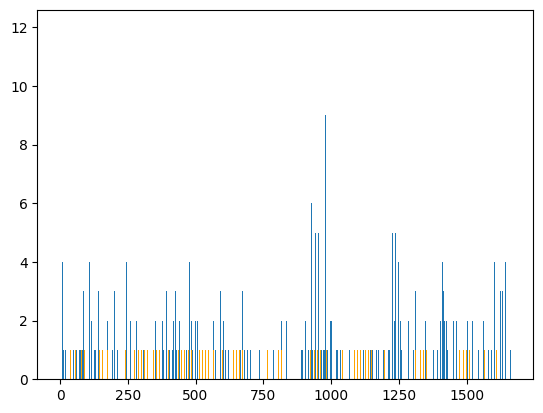

In [22]:
pylab.bar(range(len(data) - 1), interactions)
# pylab.show()
pylab.bar(range(len(data) - 1), breaks, color = "orange")
pylab.show()

In [ ]:
for sur_sent_id in range(len(data)):
    interactions = []
    for sent_id in range(len(data)):
        interactions.append(interaction(nouns[sur_sent_id], nouns[sent_id]))
    breaks = []
    for sentence_id in range(len(data)):
        if data[sentence_id] == "--- SEGMENT BRAKE ---\r\n":
            breaks.append(1)
        else:
            breaks.append(0)

    pylab.bar(range(len(data)), interactions)
    # pylab.show()
    pylab.bar(range(len(data)), breaks, color = "orange")
    pylab.show()

In [25]:
external_graph = nx.Graph()

In [31]:
ng_elements = []
for sent in data:
    if sent.strip(' \n\r\t') == '' or sent is None or sent == "--- SEGMENT BRAKE ---\r\n":
        continue
    print(sent)
    sent_graph = ng_graph(sent)
    for node in sent_graph:
        if "ng_graph" in sent_graph.nodes[node]:
            ng_elements.append([])
            ng = sent_graph.nodes[node]["ng_graph"]
            for node in ng:
                if ng.nodes[node]["pos"] == "NOUN":
                    ng_elements[-1].append(node)
                print(node)
    print("--")

В настоящей работе решается задача существования колебаний их устойчивости и стабилизация МССП состоящей из трех подсистем второго порядка в основном режиме

--------------------------------------------------------------------------------
в                   case                ADP                 работе 12
настоящий           amod                ADJ                 работе 12
работа              obl                 NOUN                решается 19
--------------------------------------------------------------------------------
решать              root                VERB                режиме 150
задача              nsubj:pass          NOUN                решается 19
существование       nmod                NOUN                задача 28
--------------------------------------------------------------------------------
колебание           nmod                NOUN                существования 35
их                  det                 DET                 устойчивости 62
устойчивость        n

In [ ]:
ng_elements

[['модель',
  'описание',
  'требование',
  'свойство',
  'принцип',
  'функционирование'],
 [],
 ['выбор',
  'воздействие',
  'достижение',
  'цель',
  'условие',
  'среда',
  'учет',
  'рассмотрение',
  'план'],
 [],
 ['данные', 'анализ', 'основа'],
 ['система'],
 ['монитор', 'ошибка'],
 ['оператор', 'действие', 'бездействие'],
 ['контекст', 'ситуация', 'последствие', 'серь'],
 ['взаимодействие', 'компонент', 'система', 'источник', 'данные'],
 [],
 [],
 ['звено',
  'функционирование',
  'природа',
  'оператор',
  'часть',
  'система',
  'управление',
  'термин',
  'специалист',
  'объект',
  'вооружение',
  'техника',
  'командир',
  'экипаж',
  'аппарат',
  'др.',
  'среда',
  'модель',
  'интерфейс',
  'орган'],
 [],
 ['цель'],
 [],
 [],
 ['нефть'],
 [],
 ['ловушка'],
 ['аннотация', 'скважина'],
 [],
 [],
 ['нефтяник'],
 ['сырье', 'добыча'],
 [],
 ['порода'],
 ['газ', 'нефть'],
 ['плотность'],
 ['вода'],
 ['добыча', 'процесс', 'углеводород'],
 [],
 ['система', 'человек'],
 ['глубин

In [119]:
external_graph = nx.Graph()
for elm in ng_elements:
    for word in elm:
        for other_word in elm:
            if word != other_word:
                if (word, other_word) in external_graph.edges:
                    external_graph.edges[(word, other_word)]["cnt"] += 1
                    continue
                if (other_word, word) in external_graph.edges:
                    external_graph.edges[(other_word, word)]["cnt"] += 1
                    continue
                external_graph.add_edge(word, other_word, cnt = 1)

In [120]:
for edge in external_graph.edges:
    print(edge, external_graph.edges[edge])

('стабилизация', 'существование') {'cnt': 4}
('стабилизация', 'колебание') {'cnt': 6}
('стабилизация', 'задача') {'cnt': 8}
('стабилизация', 'устойчивость') {'cnt': 4}
('стабилизация', 'динамика') {'cnt': 2}
('стабилизация', 'орган') {'cnt': 2}
('стабилизация', 'система') {'cnt': 6}
('стабилизация', 'тело') {'cnt': 2}
('стабилизация', 'шарнир') {'cnt': 2}
('стабилизация', 'звено') {'cnt': 2}
('стабилизация', 'манипулятор') {'cnt': 2}
('стабилизация', 'модель') {'cnt': 2}
('стабилизация', 'среда') {'cnt': 2}
('стабилизация', 'применение') {'cnt': 2}
('стабилизация', 'пример') {'cnt': 2}
('стабилизация', 'популяция') {'cnt': 2}
('стабилизация', 'олень') {'cnt': 2}
('стабилизация', 'цель') {'cnt': 2}
('стабилизация', 'численность') {'cnt': 2}
('стабилизация', 'изучение') {'cnt': 2}
('стабилизация', 'движение') {'cnt': 2}
('стабилизация', 'основа') {'cnt': 2}
('стабилизация', 'результат') {'cnt': 2}
('стабилизация', 'теорема') {'cnt': 2}
('существование', 'колебание') {'cnt': 6}
('существо

In [121]:
def interaction(word_set_1, word_set_2):
    i = 0

    if word_set_1 == [] or word_set_2 == [] or word_set_1 is None or word_set_2 is None:
        return 0
    for elm in word_set_1: # если есть одинаковые элементы, то прибавляем 1
        if elm in word_set_2: 
            i += 1
        else:
            for other in word_set_2:
                if (elm, other) in external_graph.edges:
                    eg_sim = external_graph.edges[(elm, other)]["cnt"] / 2
                else:
                    if (other, elm) in external_graph.edges:
                        eg_sim = external_graph.edges[(other, elm)]["cnt"] / 2
                    else:
                        eg_sim = 0
                i += (1 - (1 / max(eg_sim, 1))) / len(word_set_2)
    return i

In [122]:
cur_file = 25

In [123]:
test_data = []
file_name = f'segmentation_dataset/{cur_file}.txt'
import codecs
f = codecs.open( file_name, "r", "utf_8_sig" )

ng_s = []
verbs = []
for line in f:
    test_data.append(line)

In [124]:
def find_nouns(sentence):
    res = []
    doc = stanza_parser(sentence)
    try:
        for token in doc.sentences[0].words:
            if token.upos == "NOUN":
                res.append(token.lemma)
        return res
    except IndexError:
        print(doc.sentences)

nouns = []
for sent in test_data:
    nouns.append(find_nouns(sent))

In [125]:
interactions = []
skip = 0
for sent_id in range(len(test_data) - 1):
    if skip:
        skip = 0
        continue
    
    if test_data[sent_id + 1] == "--- SEGMENT BRAKE ---\r\n" and sent_id + 2 < len(test_data):
        interactions.append(interaction(nouns[sent_id], nouns[sent_id + 2]))
        print(f"OVB {sent_id} ~-~-~-~-\n{test_data[sent_id]} \n {nouns[sent_id]} \n {interactions[-1]} \n {test_data[sent_id + 2]}\n {nouns[sent_id + 2]}")
        skip = 1
        continue

    interactions.append(interaction(nouns[sent_id], nouns[sent_id + 1]))
    print(f"{sent_id} ~-~-~-~-\n{test_data[sent_id]}\n{nouns[sent_id]}\n{interactions[-1]}\n{test_data[sent_id + 1]}\n{nouns[sent_id + 1]}")

0 ~-~-~-~-
Уравнение линейного прогноза для выборки значений и имеет вид

['уравнение', 'прогноз', 'выборка', 'значение', 'вид']
3.2916666666666665
В случае если элементы выборки являются показателями имеющими предельные значения зависящие от таких факторов как например объем потребления или насыщенность рынка описывается логарифмическим трендом вида где подбираются без учета кризисных периодов

['случай', 'элемент', 'выборка', 'показатель', 'значение', 'фактор', 'объем', 'потребление', 'насыщенность', 'рынок', 'тренд', 'вид', 'учет', 'период']
1 ~-~-~-~-
В случае если элементы выборки являются показателями имеющими предельные значения зависящие от таких факторов как например объем потребления или насыщенность рынка описывается логарифмическим трендом вида где подбираются без учета кризисных периодов

['случай', 'элемент', 'выборка', 'показатель', 'значение', 'фактор', 'объем', 'потребление', 'насыщенность', 'рынок', 'тренд', 'вид', 'учет', 'период']
0.1
Определим кризис на примере дву

In [126]:
breaks = []
skip = 0
for sent_id in range(len(test_data) - 1):
    if skip:
        skip = 0
        continue
    if data[sent_id + 1] == "--- SEGMENT BRAKE ---\r\n":
        breaks.append(5)
        skip = 1
    else:
        breaks.append(0)


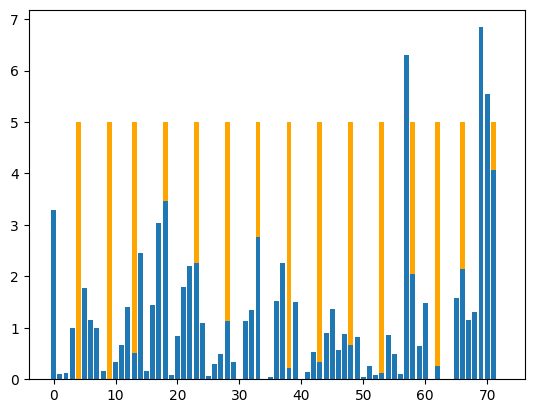

In [127]:

pylab.bar(range(len(breaks)), breaks, color = "orange")
pylab.bar(range(len(interactions)), interactions)
# pylab.show()
pylab.show()

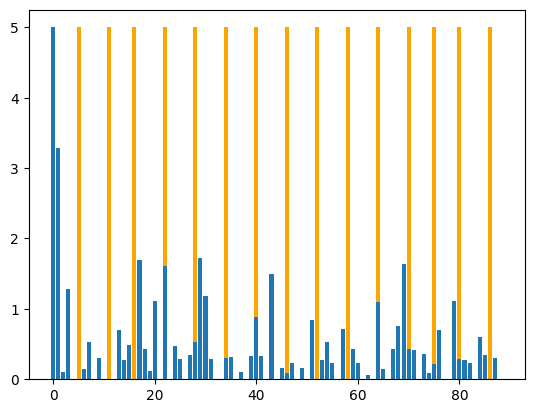

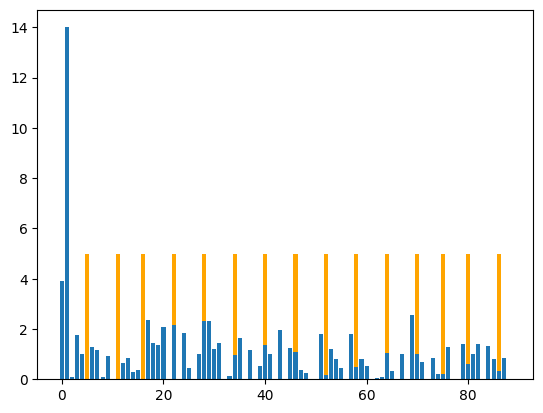

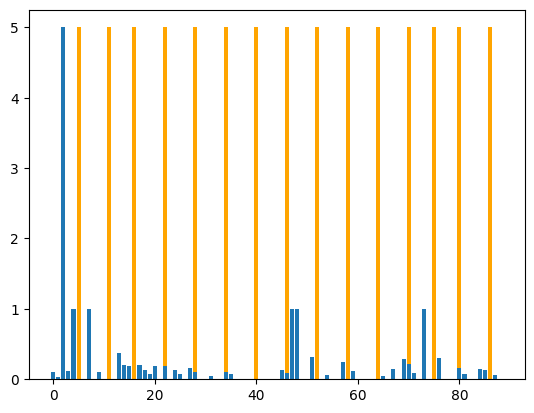

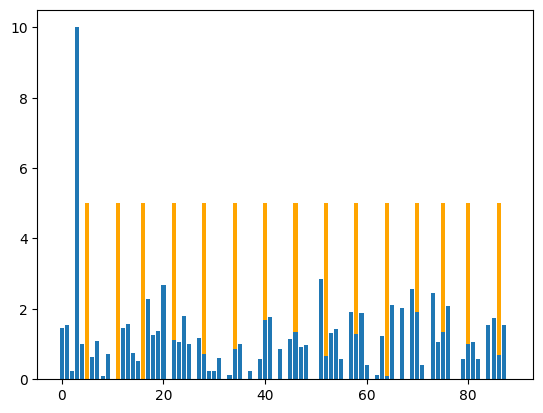

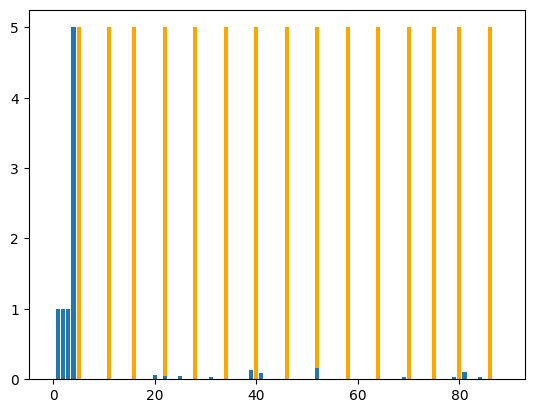

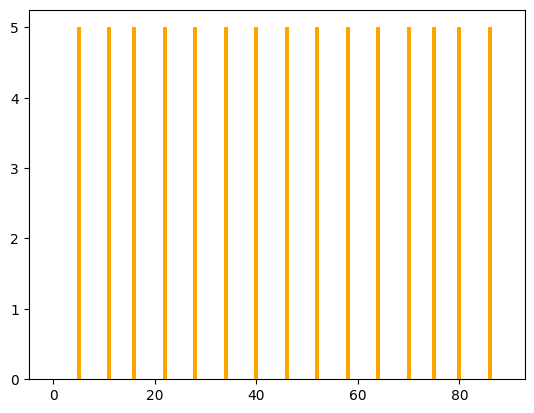

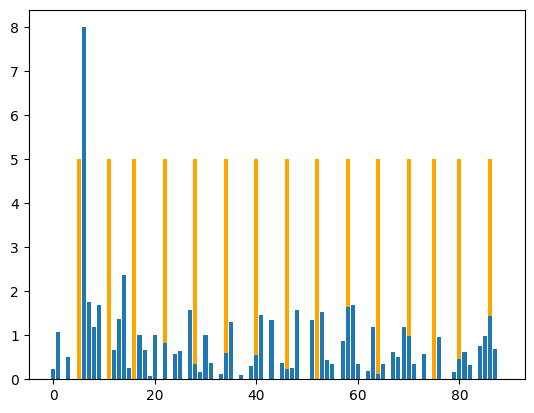

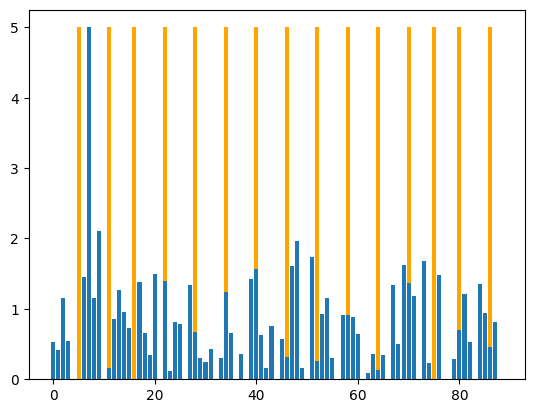

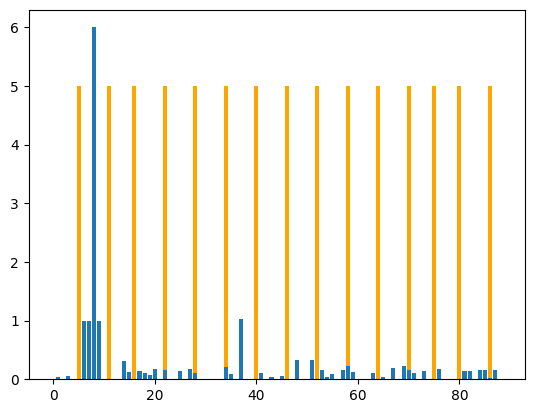

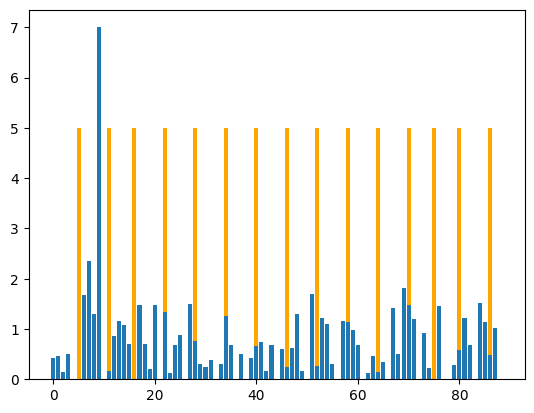

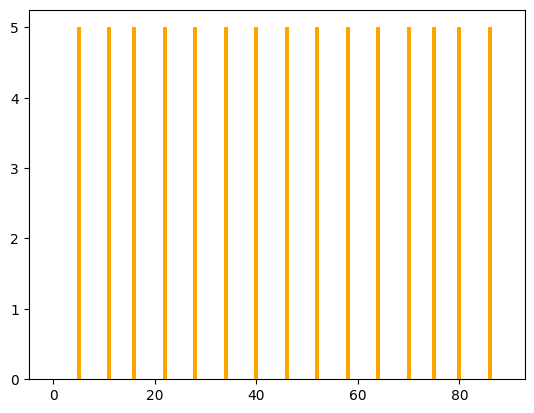

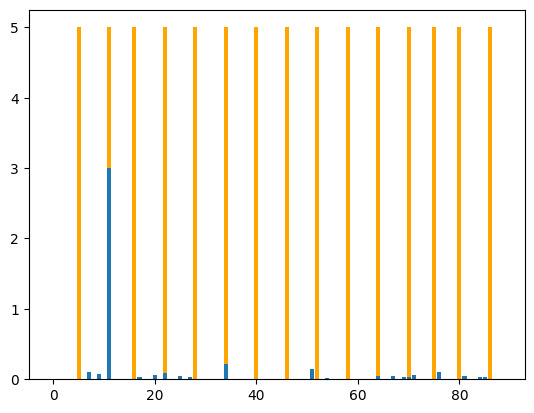

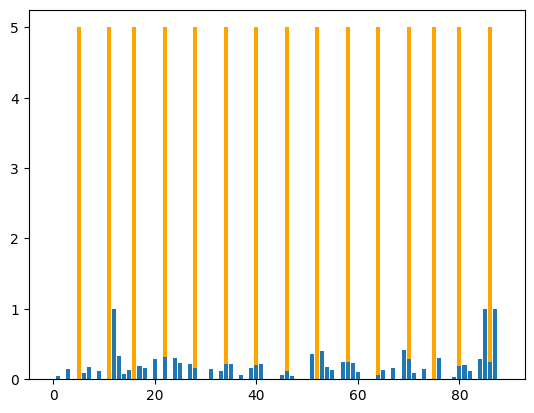

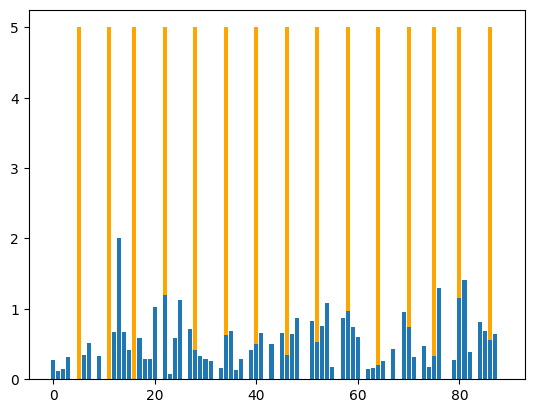

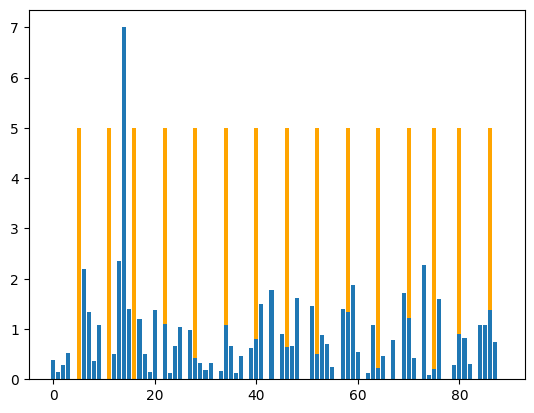

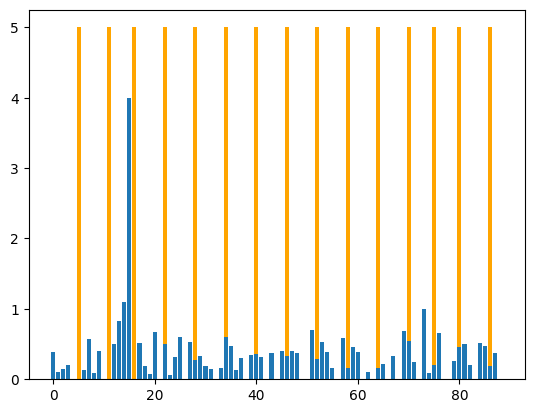

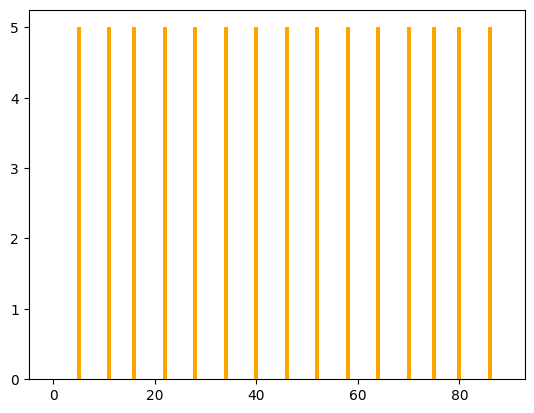

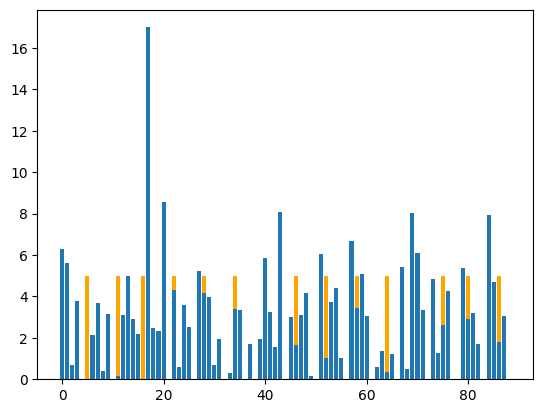

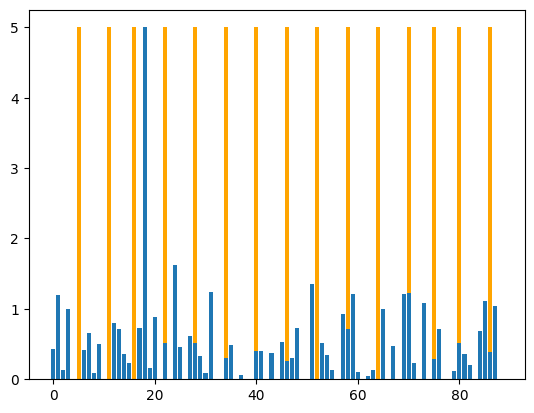

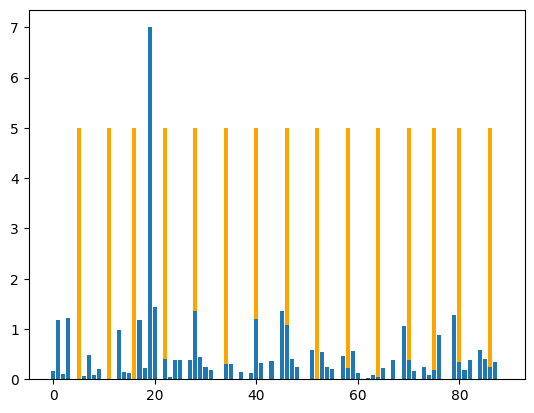

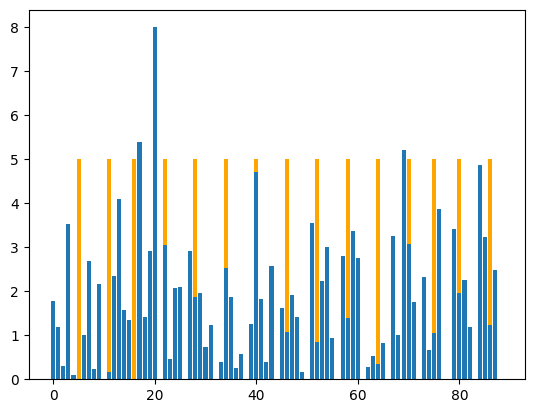

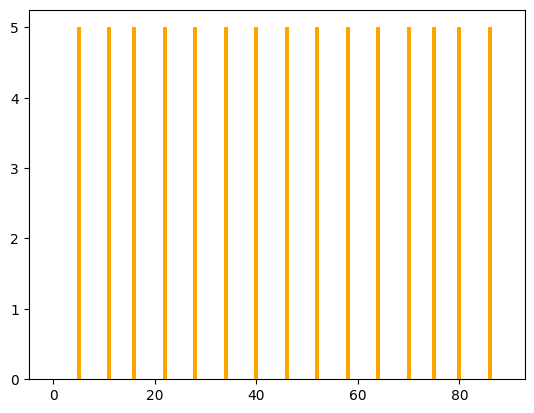

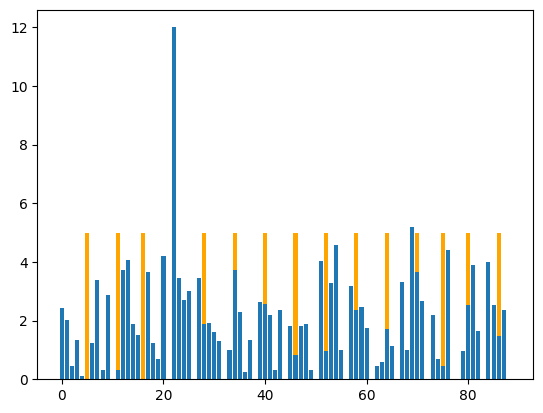

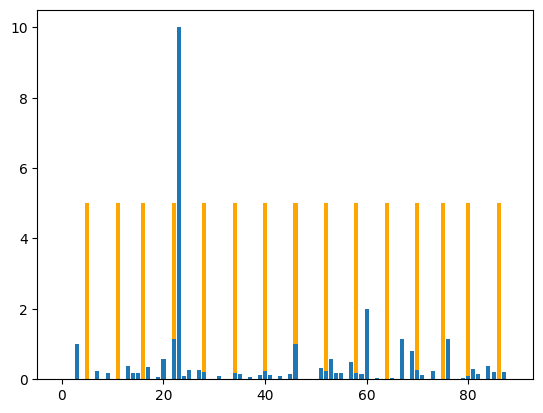

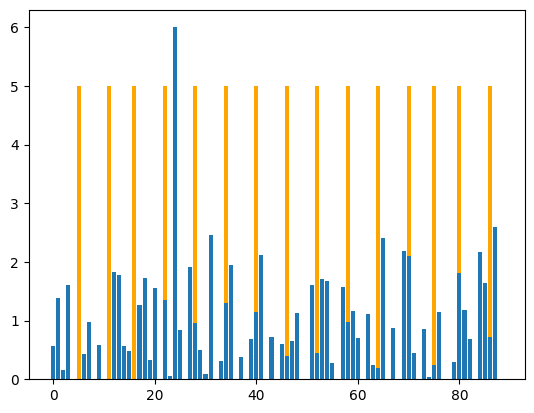

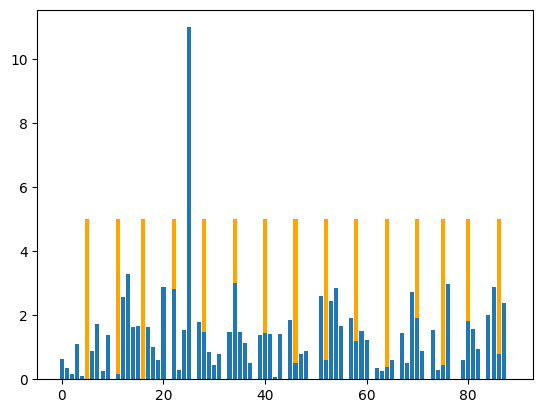

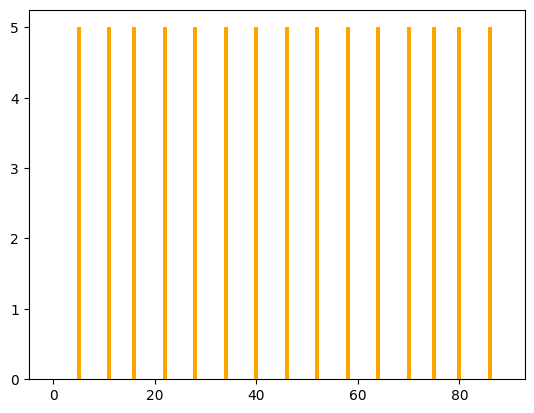

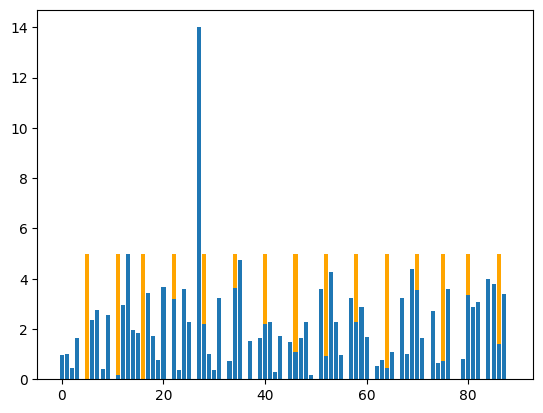

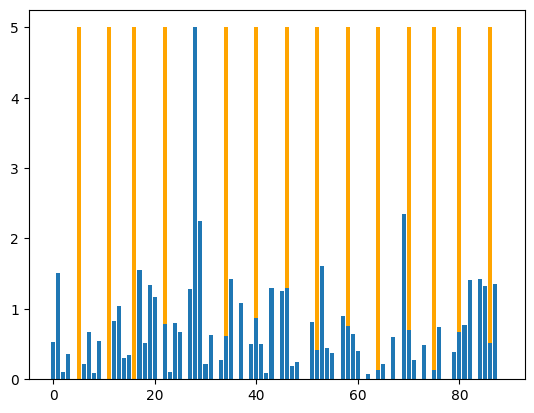

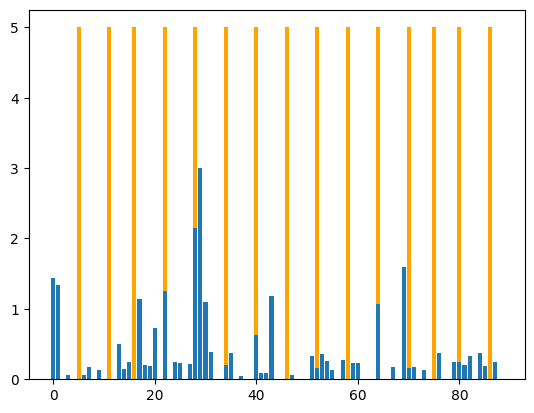

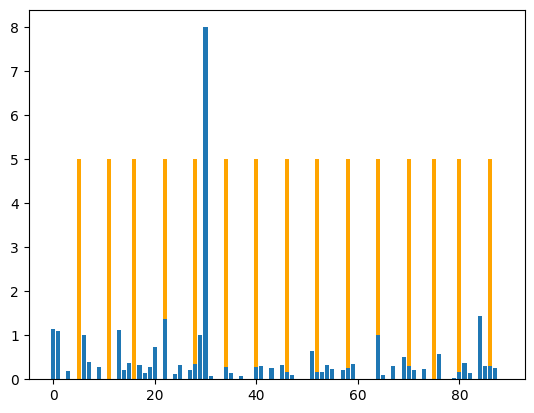

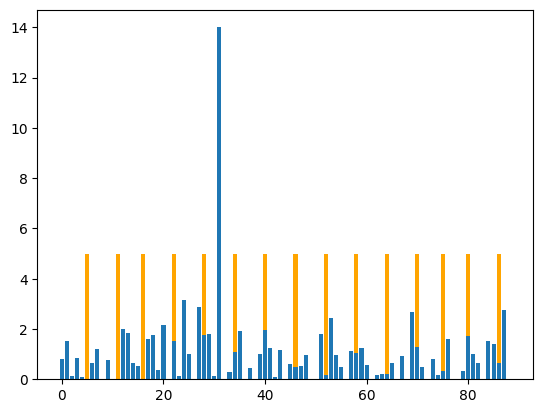

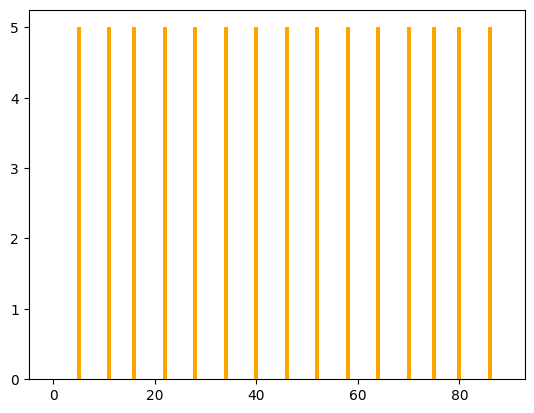

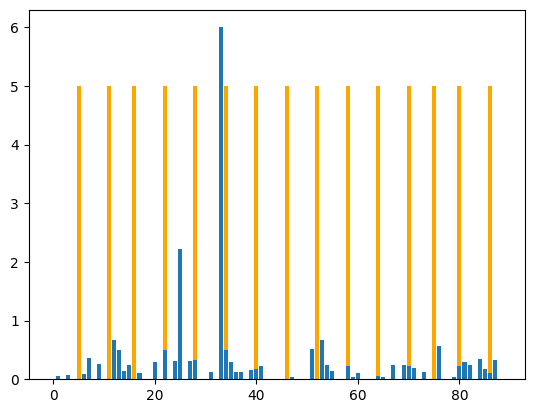

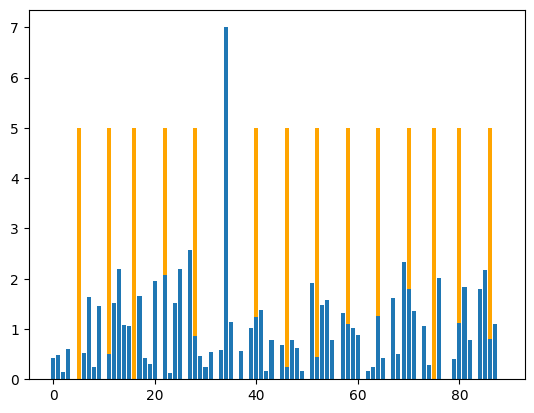

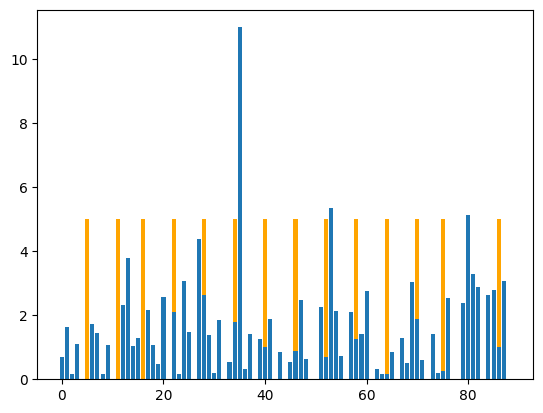

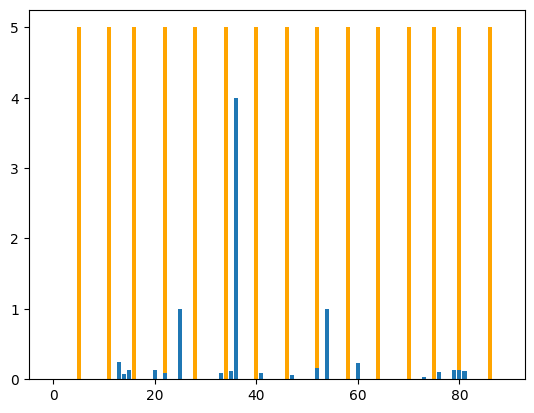

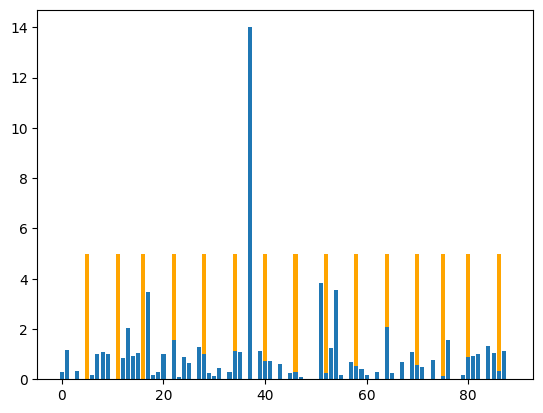

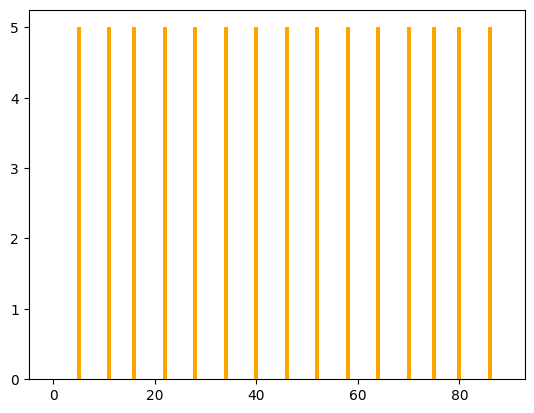

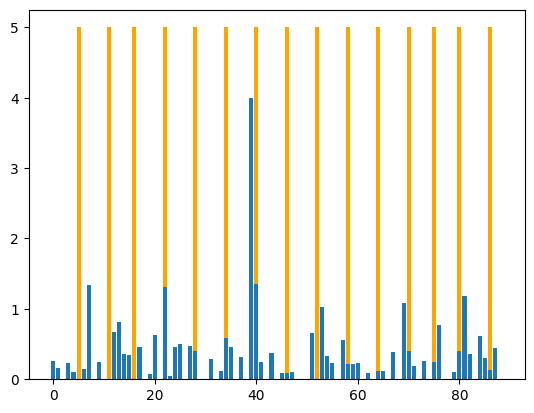

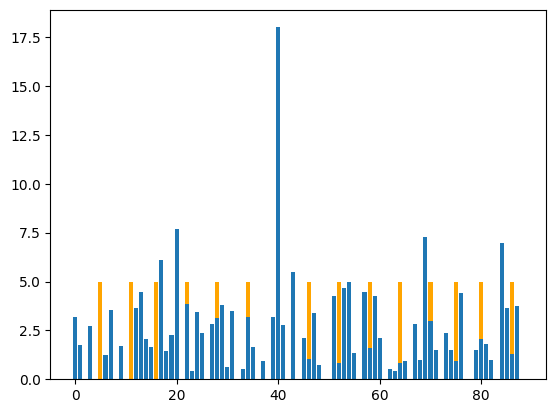

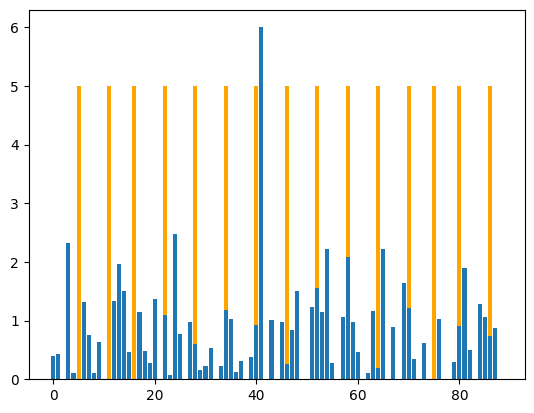

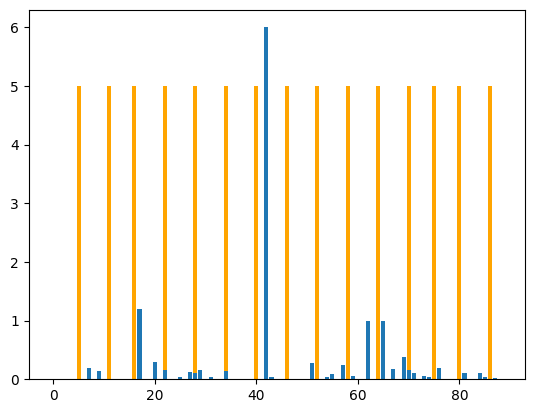

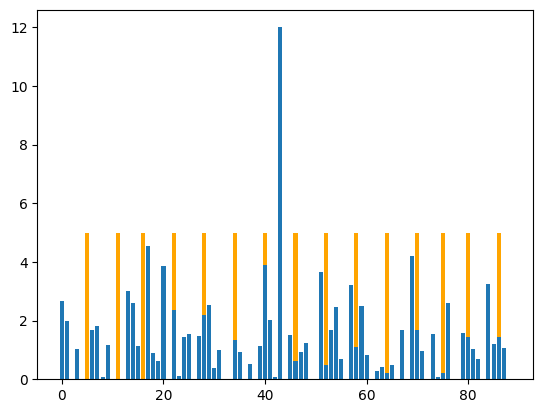

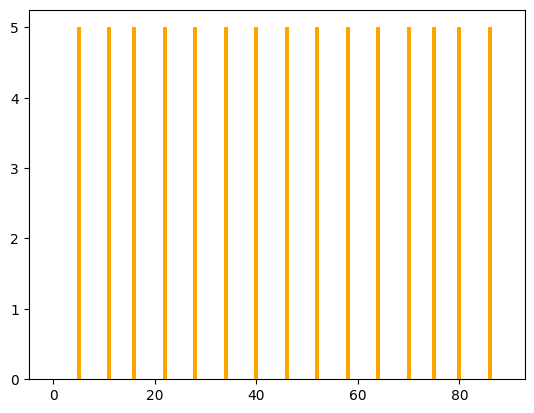

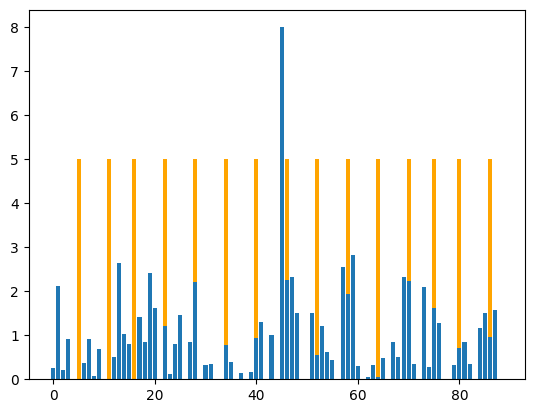

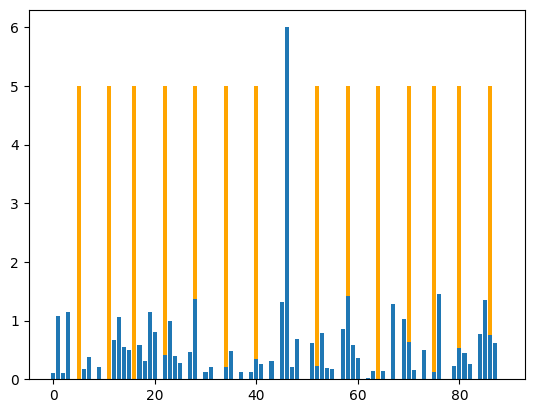

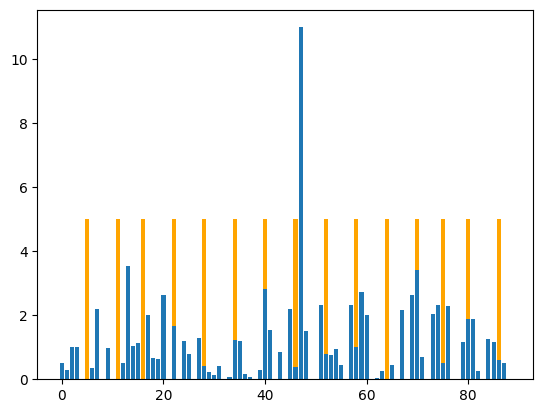

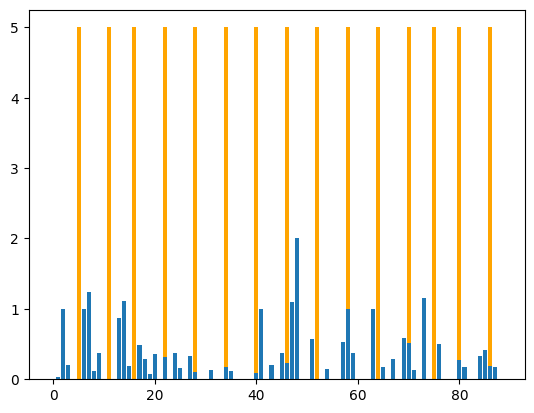

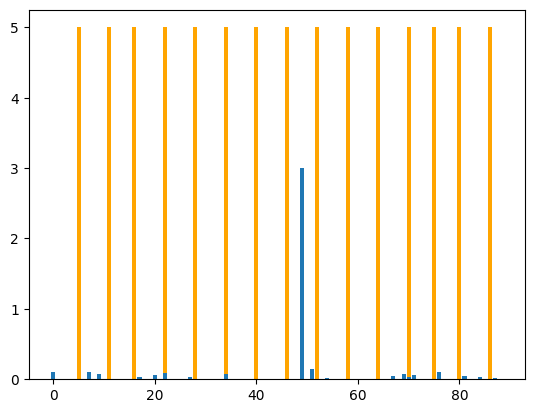

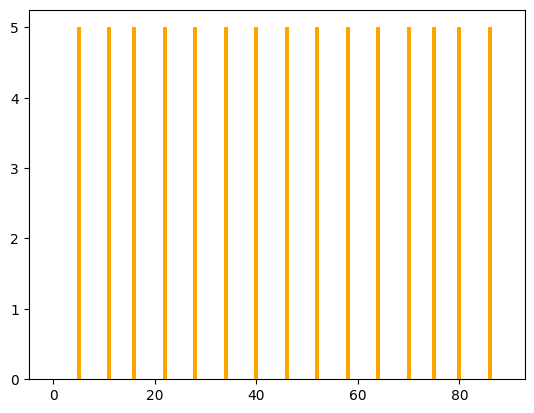

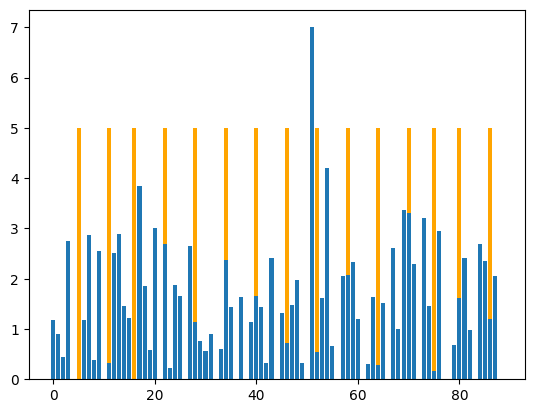

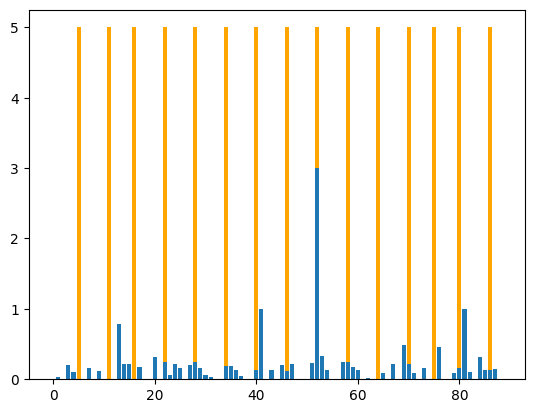

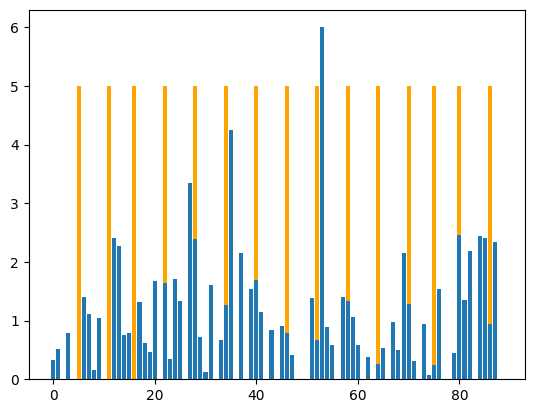

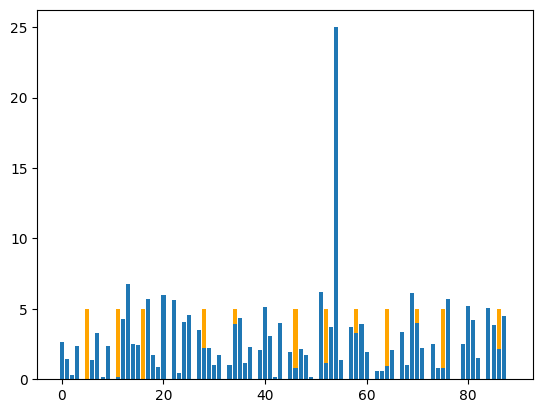

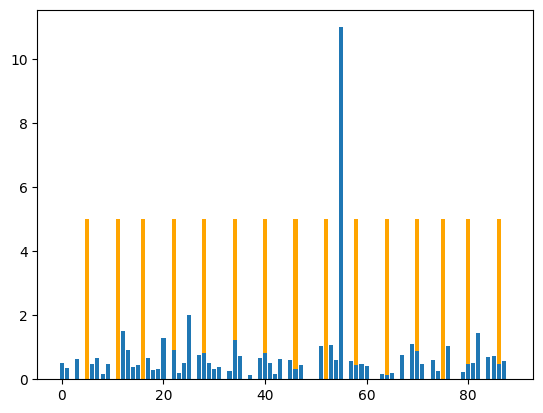

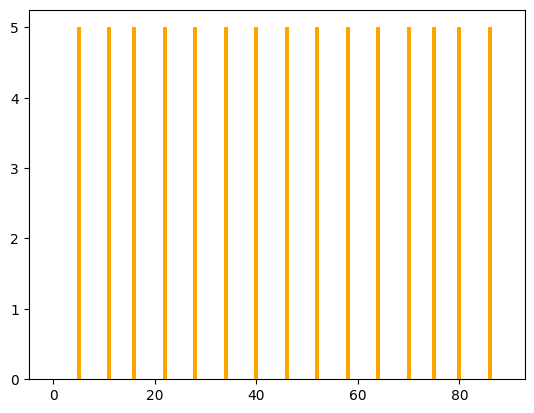

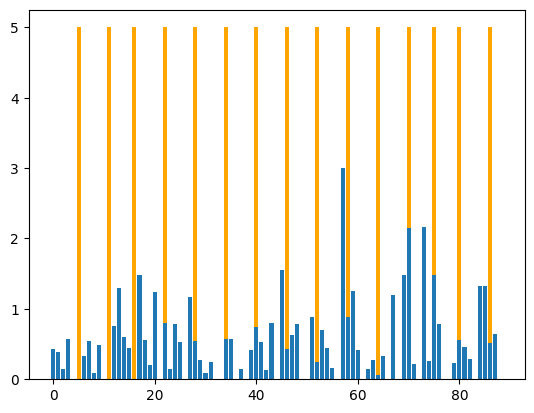

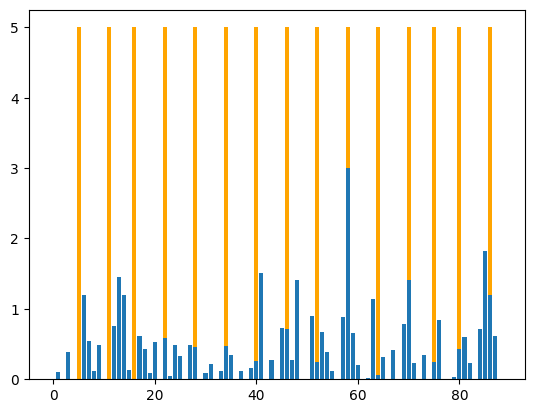

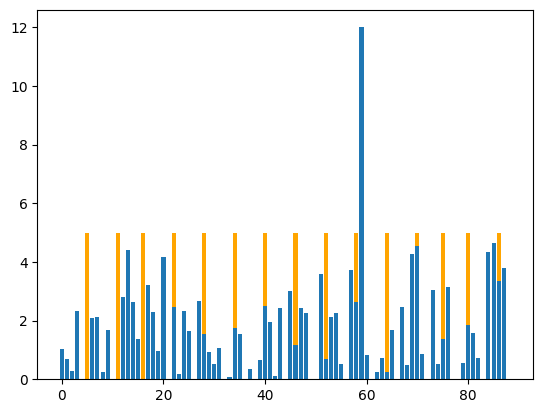

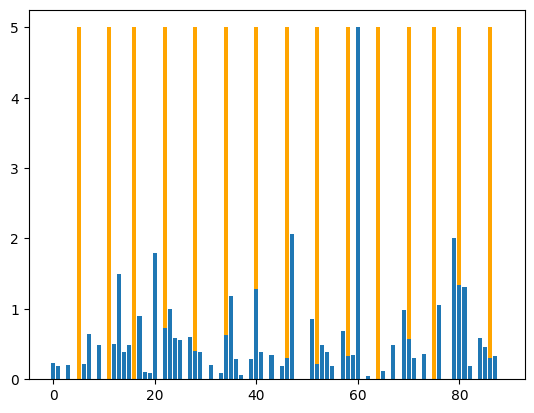

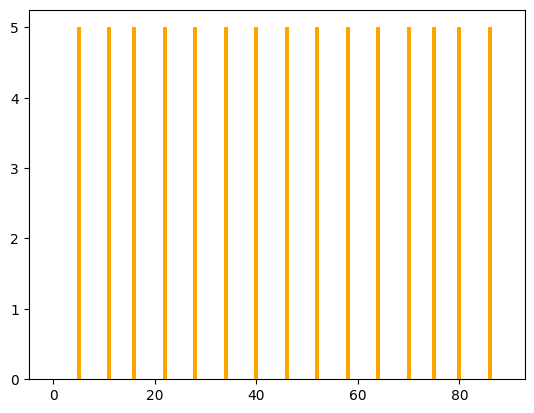

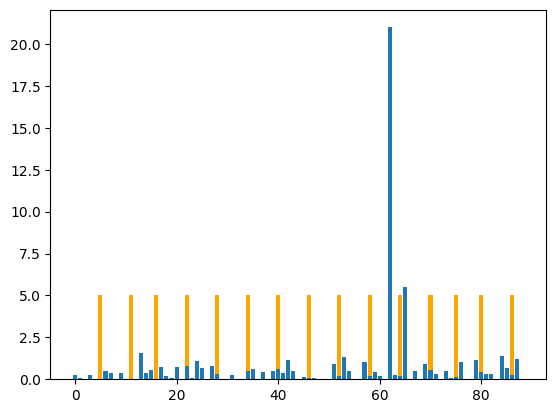

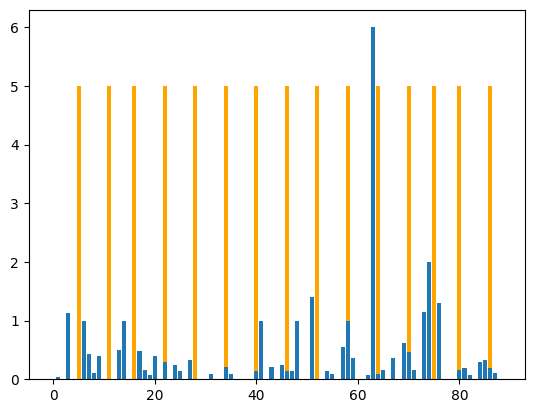

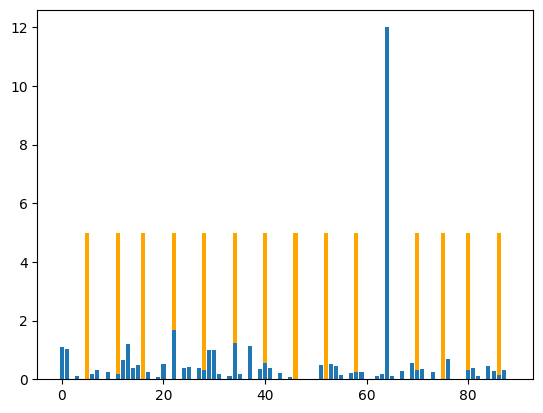

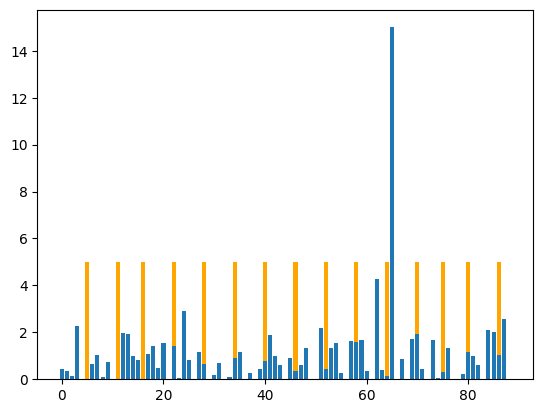

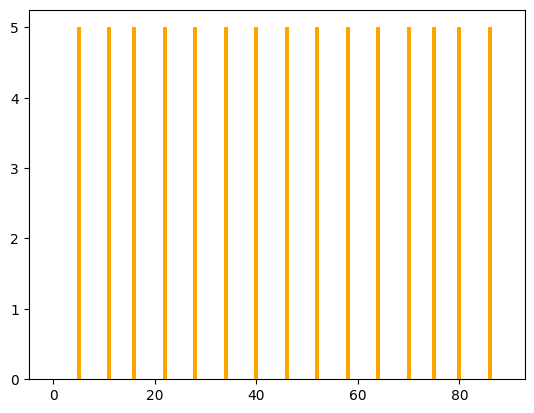

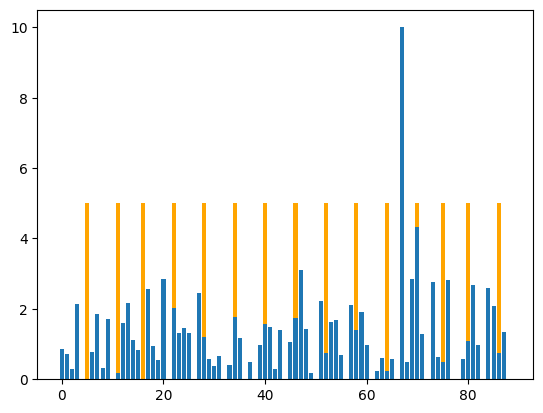

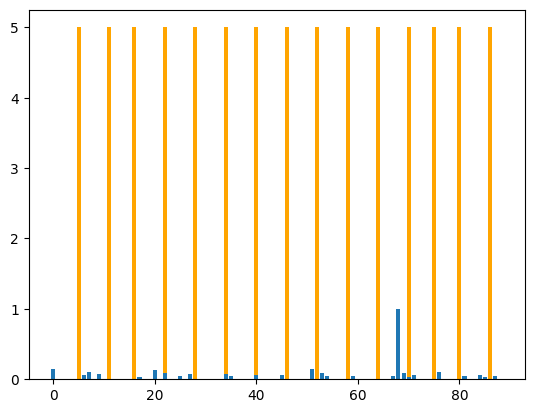

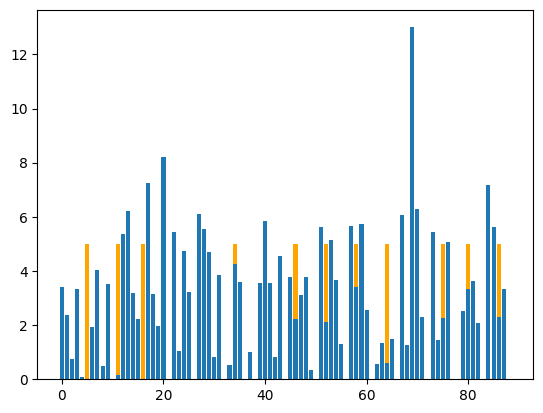

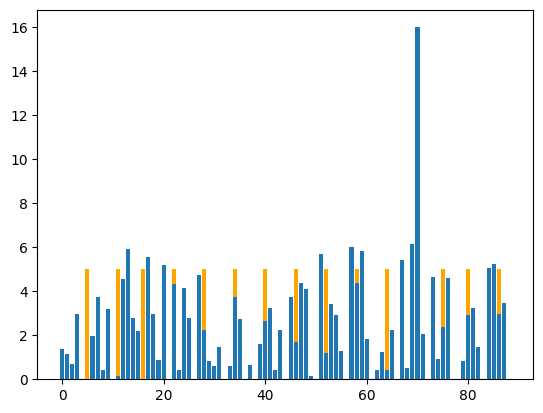

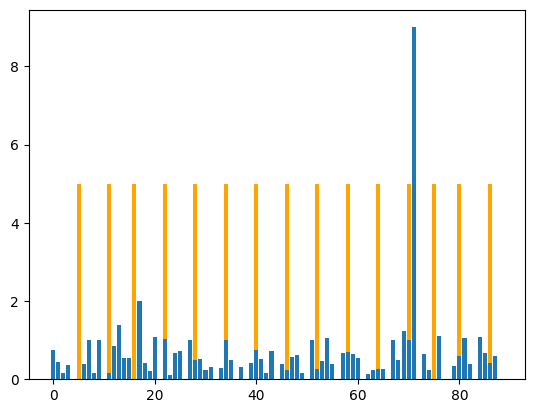

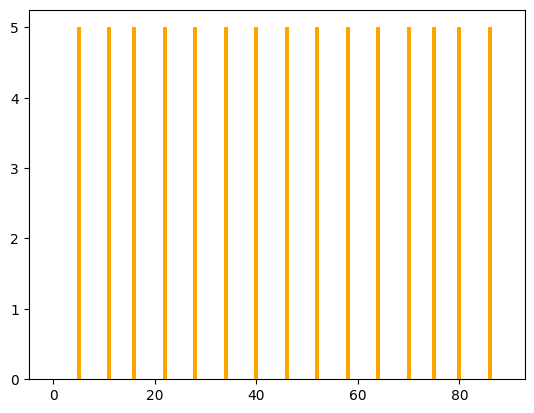

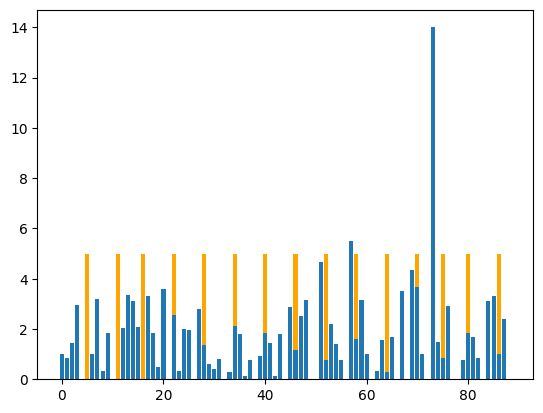

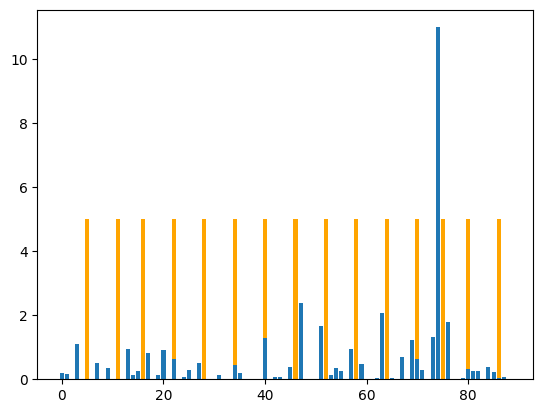

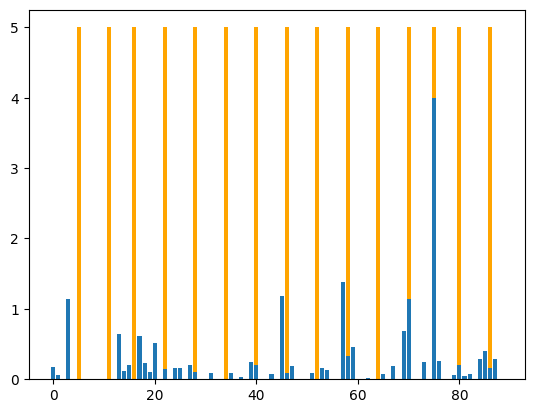

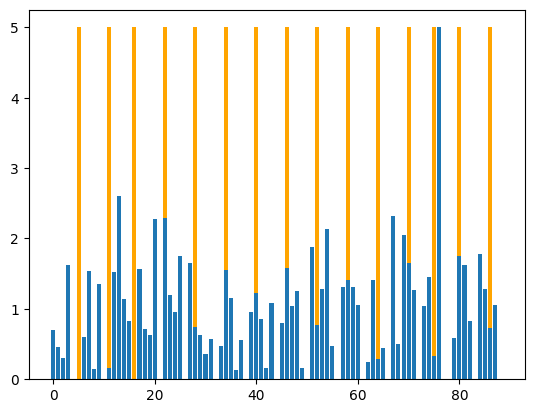

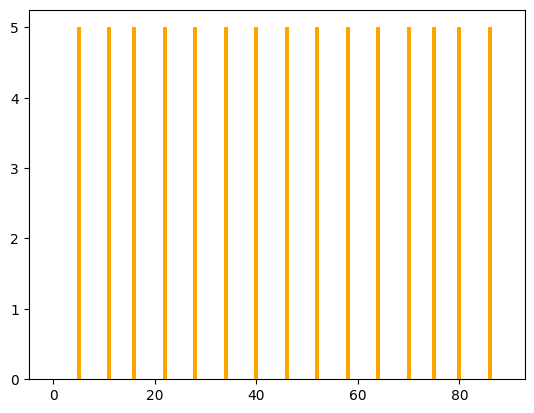

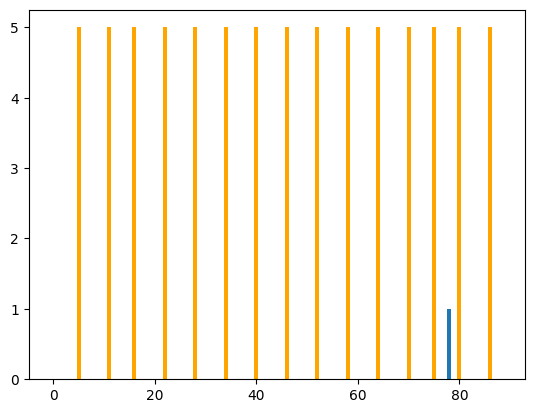

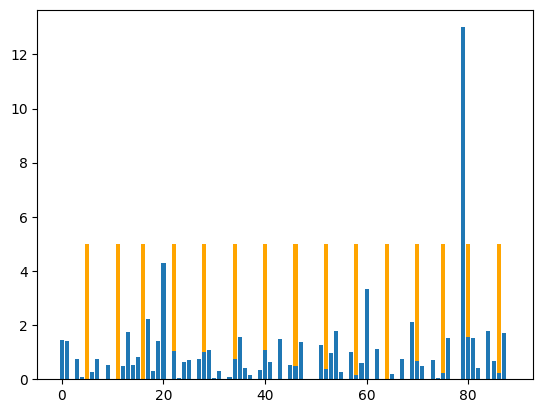

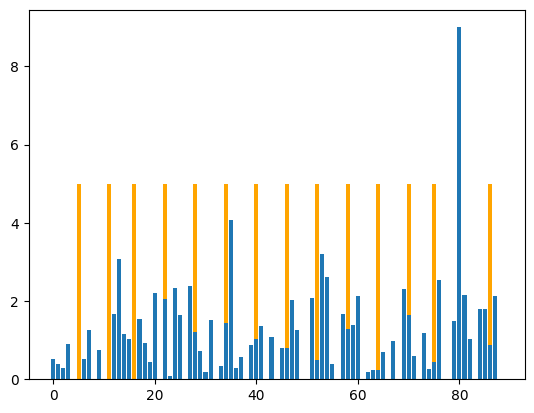

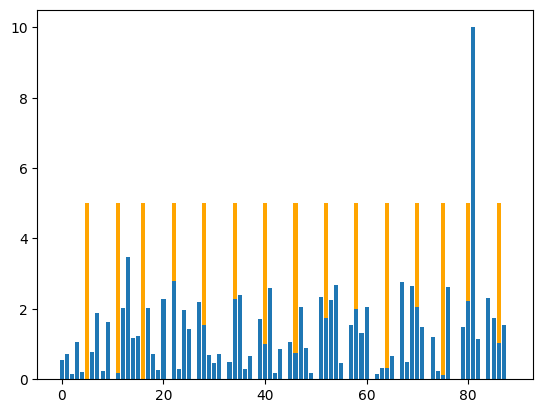

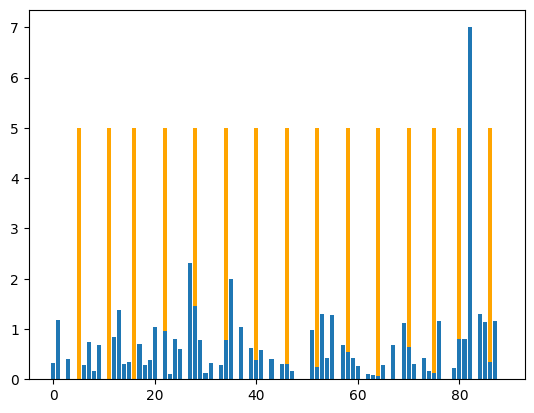

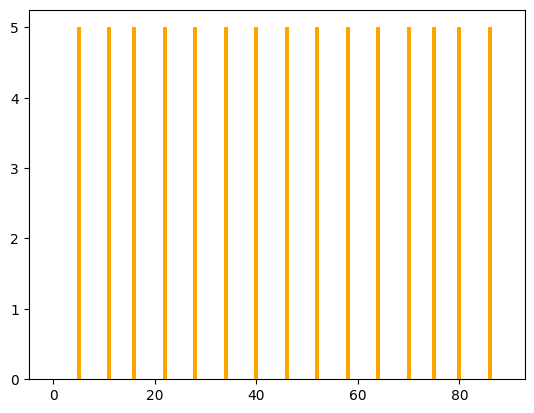

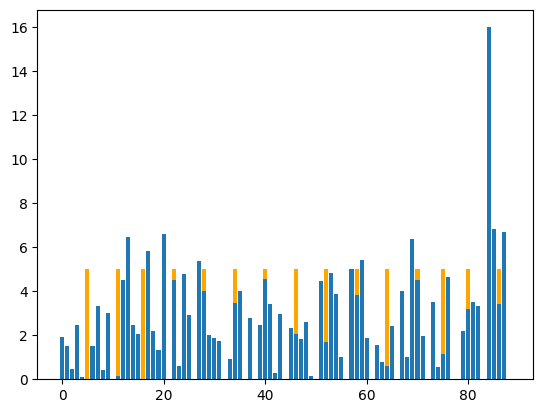

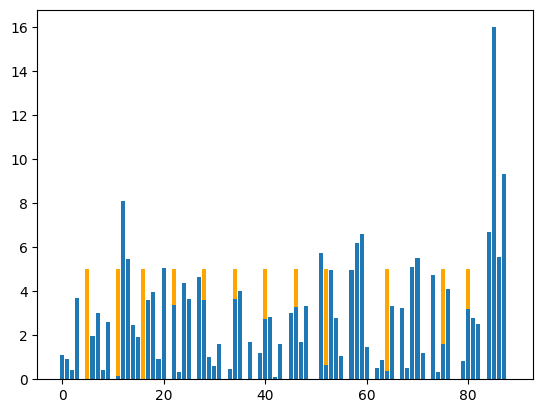

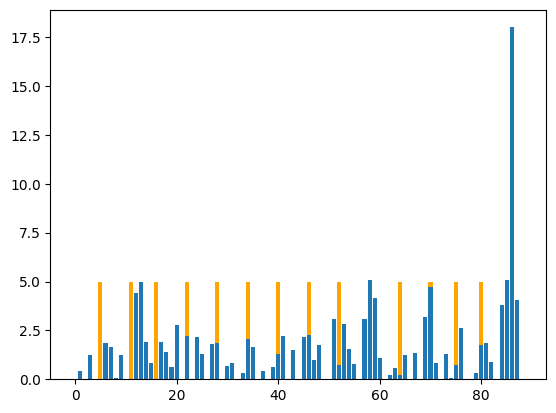

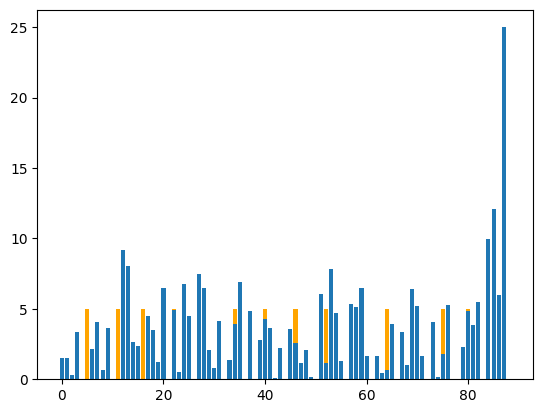

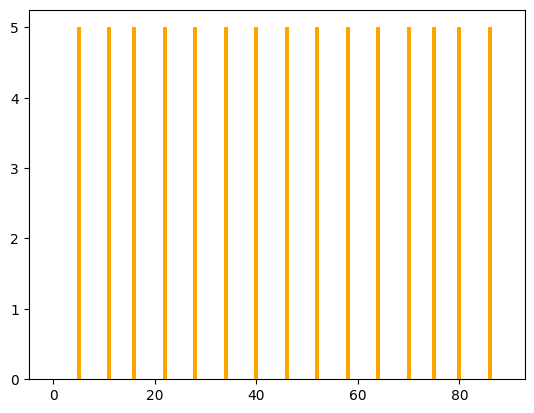

In [90]:
for cur_sent_id in range(len(test_data)):
    interactions = []
    for sent_id in range(len(test_data)):
        interactions.append(interaction(nouns[cur_sent_id], nouns[sent_id]))
    breaks = []
    for sent_id in range(len(test_data)):
        if data[sent_id] == "--- SEGMENT BRAKE ---\r\n":
            breaks.append(5)
        else:
            breaks.append(0)

    pylab.bar(range(len(test_data)), breaks, color = "orange")
    pylab.bar(range(len(test_data)), interactions)
    # pylab.show()
    pylab.show()

In [74]:
for i in range(len(test_data)):
    print(f"{interactions[i]:.3f} \t\t {test_data[i]}")

5.000 		 Уравнение линейного прогноза для выборки значений и имеет вид

3.292 		 В случае если элементы выборки являются показателями имеющими предельные значения зависящие от таких факторов как например объем потребления или насыщенность рынка описывается логарифмическим трендом вида где подбираются без учета кризисных периодов

0.100 		 Определим кризис на примере двух нефтегазовых активов ОАО Лукойл и ОАО Сургутнефтегаз

1.280 		 На основании текущей ситуации сложившейся на рынке а также исторических данных инвестор может сделать прогноз с помощью множества методов прогнозирования

0.000 		 Определим кризис как дисбаланс спроса и предложения на рынке

0.000 		 --- SEGMENT BRAKE ---

0.146 		 Одним из самых существенных критериев который указывает на положительный результат внедрения служит объем прибыли который в свою очередь сформировал увеличенный поток продаж

0.525 		 Пример который приведен выше является отражением основной классификации от внедрения системы

0.000 		 В этот пе

In [35]:
with open("external_graph.nx", "w") as f:
    json.dump(nx.node_link_data(external_graph), f)

In [79]:
with open("external_graph.nx", "r") as f:
    external_graph = nx.node_link_graph(json.load(f))

In [80]:
external_graph

In [ ]:
def display(G):
    print("---")
    for n in G.nodes:
        print(n)
    print("---")
    for e in G.edges:
        print(e)

In [ ]:
def graph_sim(G1, G2):
    sim = 0
    for node in G1.nodes:
        if node in G2.nodes:
            sim += 1
    for edge in G1.edges:
        if edge in G2.edges or reversed(edge) in G2.edges:
            sim += 1
    return sim / (max([len(G1.nodes), len(G2.nodes)]) + max([len(G1.edges), len(G2.edges)]) if max([len(G1.nodes), len(G2.nodes)]) + max([len(G1.edges), len(G2.edges)]) != 0 else 1)



In [ ]:
def edit_norm(G1, G2):
    ed = nx.graph_edit_distance(G1,G2)
    g_sum = len(G1.nodes) + len(G2.nodes)
    print( ed, g_sum)
    return ed / g_sum

In [ ]:
sims = [[]]
for sent_1 in tqdm(ng_s):
    for sent_2 in (ng_s):
        sent_sim = 0
        for g1 in sent_1:
            for g2 in sent_2:
                sent_sim += graph_sim(g1,g2)
        sims[-1].append(sent_sim / max(1, max([len(sent_1), len(sent_2)])))
    sims.append([])

100%|██████████| 87/87 [00:04<00:00, 17.99it/s]


In [ ]:
v_sims = [[]]
for sent_1 in tqdm(verbs):
    for sent_2 in (verbs):
        sent_sim = 0
        sent_sim += graph_sim(sent_1,sent_2)
        v_sims[-1].append(sent_sim)
    v_sims.append([])

100%|██████████| 87/87 [00:00<00:00, 1575.51it/s]


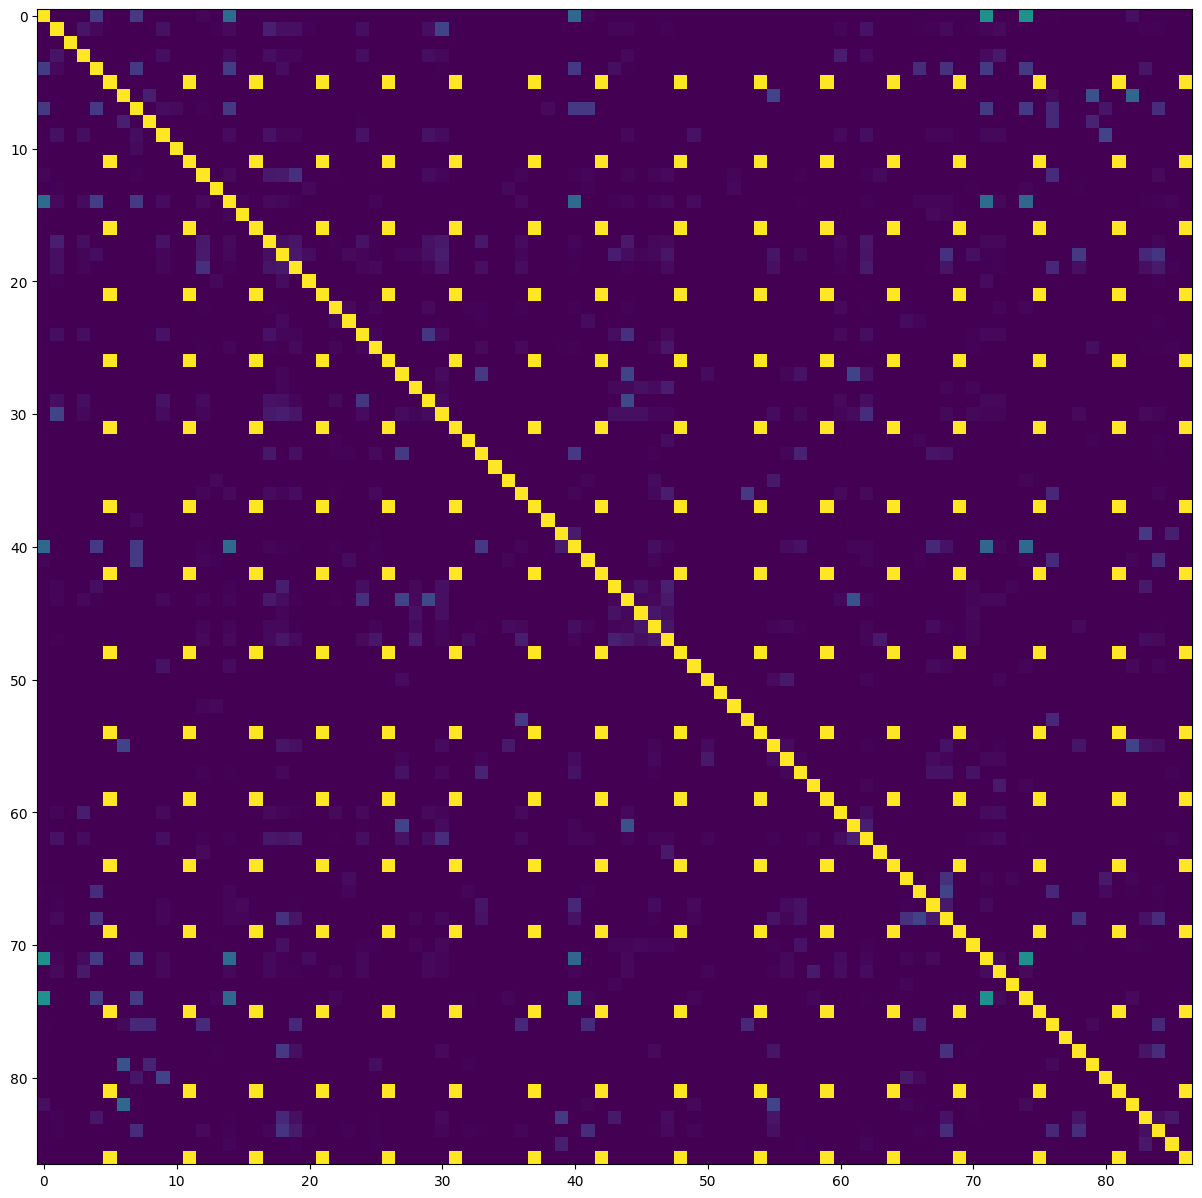

In [ ]:
pylab.figure(figsize = (15,15))
pylab.imshow(np.array(sims[:-1]))# interpolation='nearest')

In [ ]:
g_sims = [[]]
for sent_1 in tqdm(grs):
    for sent_2 in (grs):
        sent_sim = graph_sim(sent_1,sent_2)
        g_sims[-1].append(sent_sim)
    g_sims.append([])

100%|██████████| 87/87 [00:00<00:00, 619.75it/s]


In [ ]:
grs[0].edges()

OutEdgeView([('концептуальный', 'модель'), ('модель', 'понимать'), ('иип', 'модель'), ('иип', 'функционирование'), ('быть', 'понимать'), ('описание', 'понимать'), ('требование', 'описание'), ('общий', 'свойство'), ('свойство', 'требование'), ('принцип', 'свойство'), ('функционирование', 'принцип')])

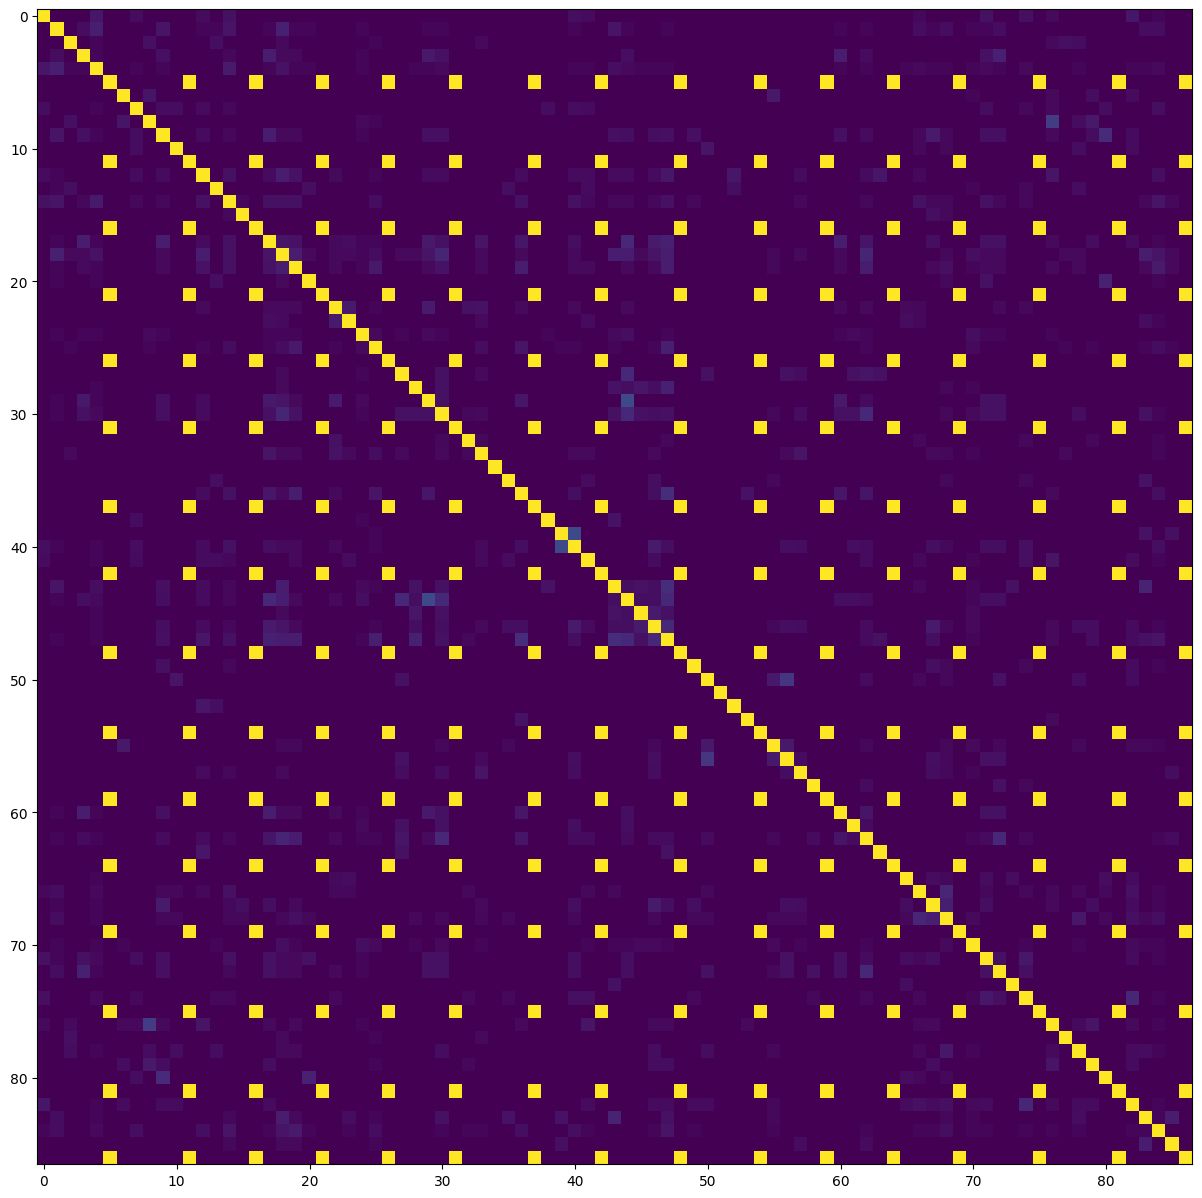

In [ ]:
pylab.figure(figsize = (15,15))
pylab.imshow(np.array(g_sims[:-1]))# interpolation='nearest')

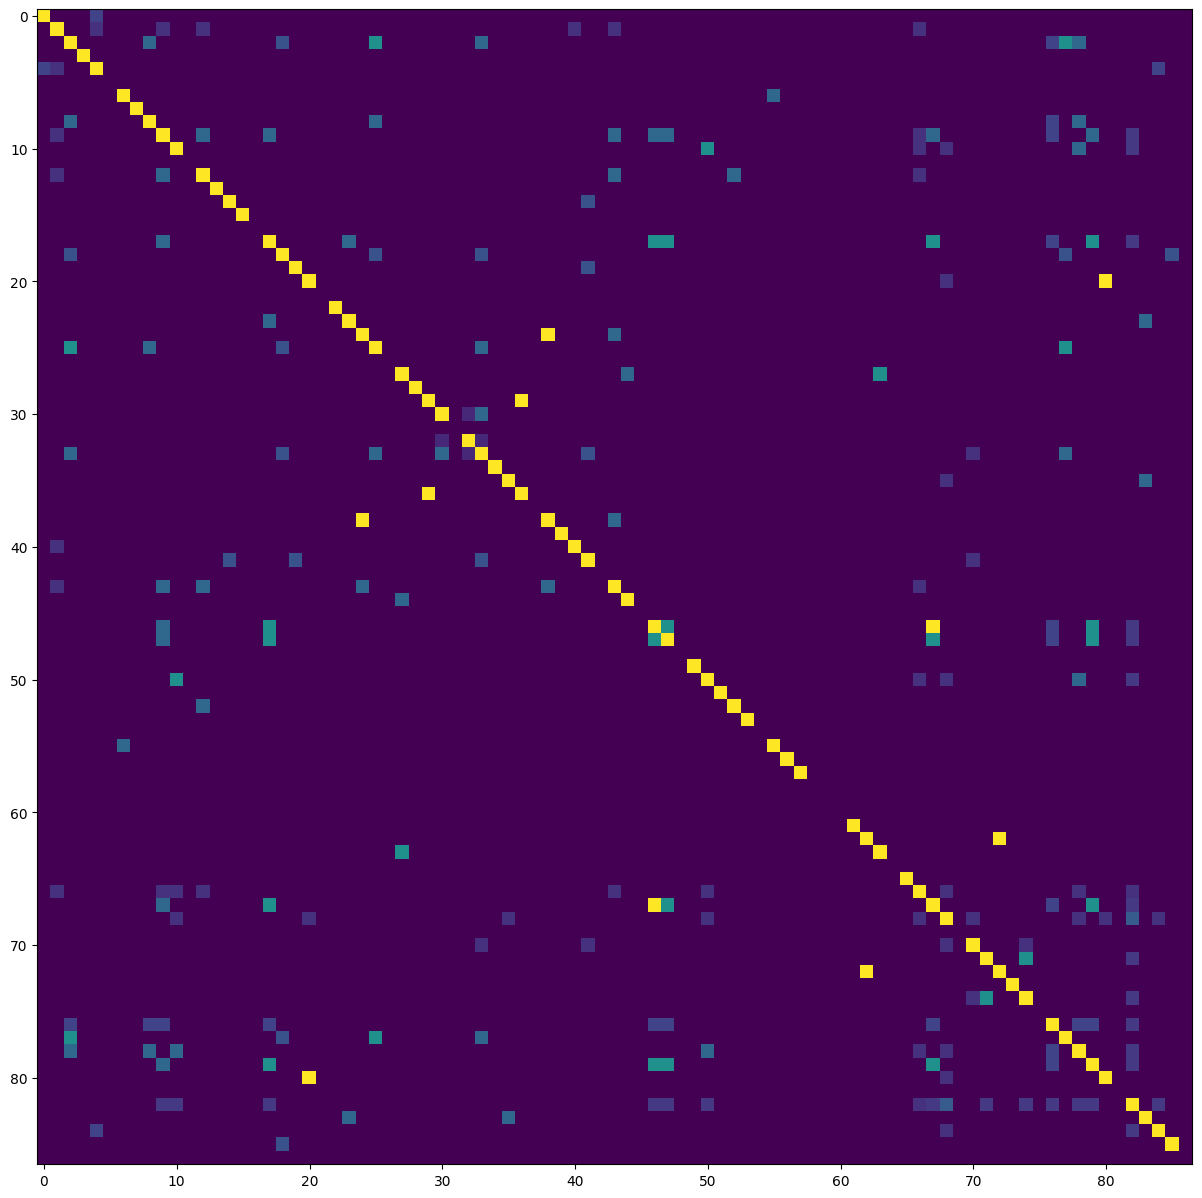

In [ ]:

pylab.figure(figsize = (15,15))
pylab.imshow(np.array(v_sims[:-1]))# interpolation='nearest')